In [1]:
import os
import sys

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import json
from pathlib import Path
import cv2

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

project_path = "../"
sys.path.append(project_path)

from src.model.segmentation_model import HoneyBeeModel

from src.datamodule.datasets.custom_datasets import CustomDataset, CustomTestDataset, CustomDatasetBatch, CustomDatasetBatchNew
from src.utils import utils
from src.losses.losses import dice_loss

from PIL import ImageColor

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%load_ext autoreload
%autoreload 2


## Read config

In [2]:
# get config
from hydra import compose, initialize
from omegaconf import OmegaConf


initialize(config_path="../config", job_name="test_app")
cfg = compose(config_name="config")


In [3]:
img_names = [i for i in os.listdir("../" + cfg.datamodule.dataset_args.train.images_path) if not i.startswith(".")]
img_names

['Cam_1_2019-08-01T15_28_56.737066+00_00.png',
 'Cam_0_2019-08-27T15-30-54+00-00.png',
 'Cam_0_2019-08-30T15-30-45+00-00.png',
 'Cam_0_2019-09-07T14-30-08+00-00.png',
 'Cam_0_2019-07-24T15_29_46.791050+00_00.png',
 'Cam_1_2019-07-24T15_29_47.541673+00_00.png']

## prepare labels and colors


In [4]:
path_label_classes = "/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/label_classes.json"

with open(path_label_classes, "r") as f:
    label_classes = json.load(f)

In [5]:
cmap = {}
labels = {}

labels[0] = "background" 
for i, alpha in zip(label_classes, np.linspace(0.5, 1,len(label_classes))):
    color = ImageColor.getcolor(i['color'],"RGB")
    
    cmap[i["png_index"]] = [i/255 for i in color] + [alpha]
    labels[i["png_index"]] = i["name"]
    
cmap[0] = [1,1,1,1]


## Get train-data

In [6]:
bees_train_data = CustomDatasetBatchNew(images_path = "data/train/images", labels_path = "data/train/labels", img_size = 'default', crop_size = 224, n_crops_in_batch = 16, phase = 'train')
bees_train_dataloader = DataLoader(bees_train_data, batch_size = 16, shuffle = False, drop_last = False)

print(len(bees_train_data))
image, mask = bees_train_data[0]
print(image.size())

96
torch.Size([1, 224, 224])


In [8]:
len(bees_train_data)

96

In [12]:

image, mask = next(iter(bees_train_dataloader))
image.size()

torch.Size([16, 1, 224, 224])

In [94]:
%%timeit
image, mask = next(iter(bees_train_dataloader))
image.size()

3.03 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


torch.Size([1, 224, 224])

In [18]:
print(n)

16


In [81]:
grid_img.size()

torch.Size([3, 1810, 454])

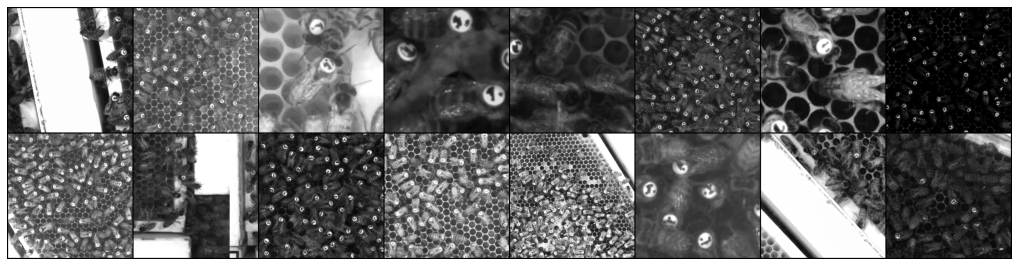

In [18]:
plt.figure(figsize =(18,12))
grid_img = torchvision.utils.make_grid(image, nrow=2)
plt.imshow(grid_img.permute(2,1,0)[...,0].squeeze().numpy(), cmap = 'gray')
plt.axis('off')
plt.show()

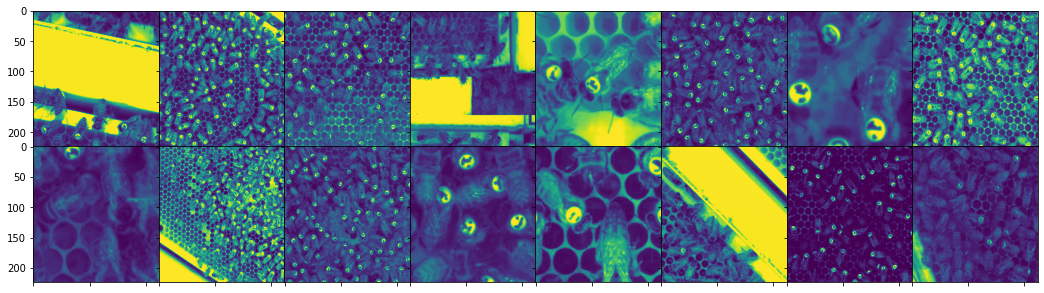

In [16]:
fig, ax = plt.subplots(2,8, figsize = (18,5),  sharex=True, sharey=True)

n = 0
for i in range(2):
    for j in range(8):
        ax[i][j].imshow(image[n,...].squeeze().cpu().numpy(), aspect = 'auto')
        n += 1
        ax[i][j].set_xticklabels([])
        #ax[i][j].set_yticklabels([])
       #ax[i][j].set_aspect('equal')
        
        
plt.subplots_adjust(wspace=0.0, hspace=0.0)



plt.show()

## Test transforms

In [20]:
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


(3000, 4000)
(2400, 4000)


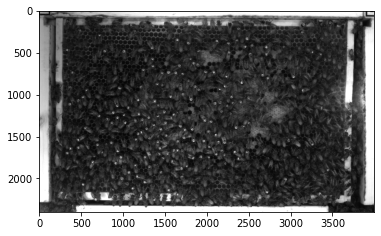

In [9]:
image = cv2.imread(r"/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/train/images/Cam_0_2019-07-24T15_29_46.791050+00_00.png", 0)
print(image.shape)
images_folder = "/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/train/images/"
masks_folder = "/srv/data/ivan_matoshchuk_new/honeybee_cells_segmentation/data/train/labels/"

images = [i for i in os.listdir(images_folder)[:1] if not i.startswith(".")]
masks = [i for i in os.listdir(masks_folder)[:1] if not i.startswith(".")]

# combine into one big image
image = np.concatenate([cv2.imread(os.path.join(images_folder, i), 0)[200:2600,:] for i in images])
mask = np.concatenate([cv2.imread(os.path.join(masks_folder, i), 0)[200:2600,:] for i in masks])

print(image.shape)

plt.imshow(image, cmap = 'gray')

In [16]:
crop_size = 224

height = 2800
width = 4000

p = 1

list_trans = [ #A.RandomCrop(height=height, width=width, always_apply=True, p=1),    
    # A.CLAHE(p = p),
    # A.Rotate(limit=(-90, 90), p = p),
    # A.HorizontalFlip(p=p),
    # A.VerticalFlip(p=p),
    # A.ShiftScaleRotate(scale_limit=0.5, p = p),
    # A.RandomBrightnessContrast(p = p),
    A.SmallestMaxSize(max_size=512, p = 1),
    # A.RandomGamma(p=p),  # changes image's luminance
    # A.RandomCrop(height=crop_size, width=crop_size, always_apply=True, p=1),
    # A.Normalize(mean=0, std=1),
    # ToTensorV2(),
]


augmentation = A.Compose(list_trans)

In [18]:
%%timeit
augmented = augmentation(image = image)

179 µs ± 7.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [196]:
%%timeit
augmented = augmentation(image = image)

210 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
augmented = augmentation(image = image, mak = mask)

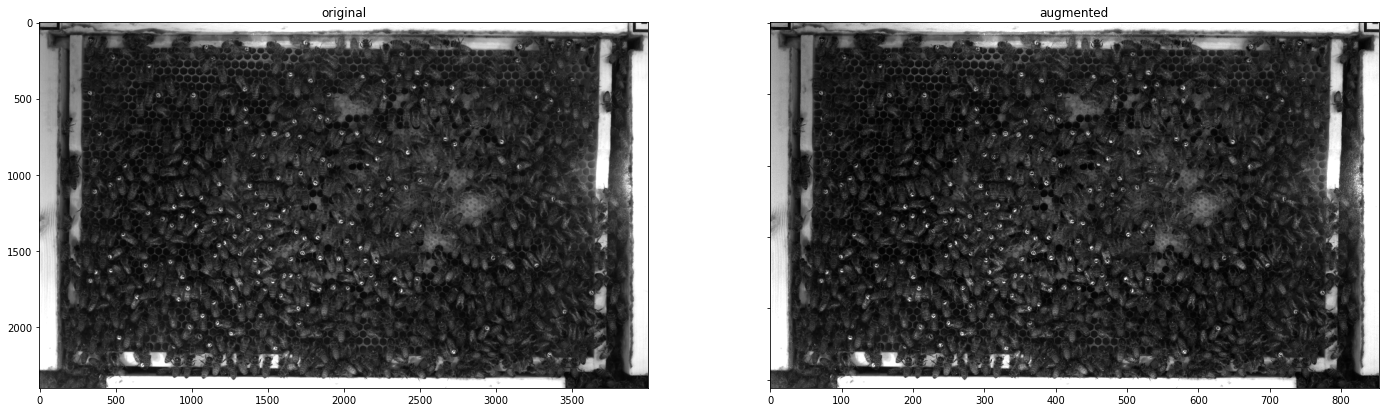

In [19]:
plt.figure(figsize = (24,24))

ax = plt.subplot(121)
ax.imshow(image, cmap = 'gray')
ax.set_title("original")

ax = plt.subplot(122)
ax.imshow(augmented['image'].squeeze(), cmap = 'gray')
ax.set_yticklabels([])
ax.set_title("augmented")
plt.show()